# Описание проекта

В рамках данного проекта мы исследуем поведение пользователей мобильного приложения нашего стартапа, который продаёт продукты питания. Основная задача заключается в том, чтобы понять, как пользователи проходят воронку продаж, выявить узкие места и оптимизировать путь к покупке.

Основные задачи проекта:

1. Анализ воронки продаж: 
   - Изучить, сколько пользователей доходит до стадии покупки и на каких именно этапах они «застревают». 
   - Выявить факторы, влияющие на отток пользователей на каждом шаге.

2. Исследование результатов A/A/B-эксперимента: 
   - Проанализировать поведение пользователей в условиях изменений шрифтов в приложении. 
   - Оценить, как новые шрифты воспринимаются по сравнению с прежними.

План работы:

1. Провести анализ воронки продаж, выявить ключевые показатели эффективности.
2. Реализовать A/A/B-тестирование: разделить пользователей на три группы — две контрольные с предыдущими шрифтами и одну экспериментальную с новыми. 
3. Сравнить результаты между группами, определить, какой шрифт лучше и почему.
4. Рассмотреть, как полученные данные могут быть использованы для дальнейших улучшений приложения.

Создание двух контрольных групп (A) вместо одной предоставляет дополнительные преимущества. Это позволит подтвердить точность проведенного тестирования: если результаты обеих контрольных групп совпадают, это увеличивает уверенность в результатах. В противном случае, значительные различия помогут выявить факторы, которые могли исказить данные.

При работе с общей аналитикой и A/A/B-экспериментом важно использовать одни и те же данные. Наши аналитики будут учитывать качество работы приложения, опираясь на общие метрики, не забывая о принадлежности пользователей к экспериментальным группам.
Ход проекта

Описание данных

Каждая запись в логе — это действие пользователя, или событие. 

EventName — название события;

DeviceIDHash — уникальный идентификатор пользователя;

EventTimestamp — время события;

ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

# Подготовка данных
## Загрузка данных

In [1]:
# импортируем библиотеки

import pandas as pd
import numpy as np
import math as mth

import matplotlib.pyplot as plt

from matplotlib.dates import DateFormatter
import plotly.express as px
from plotly import graph_objects as go

import matplotlib as mpl
import seaborn as sns
import math
import datetime as dt
import scipy.stats as stats
import datetime

from scipy import stats as st

# убираем scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# снимаем ограничение на количество столбцов и их ширину
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [2]:
# загружаем данные

df = pd.read_csv('/datasets/logs_exp.csv', sep='\t')

In [3]:
df.sample(5)

,EventName,DeviceIDHash,EventTimestamp,ExpId
12875,MainScreenAppear,65356103704674532,1564652969,246
200774,MainScreenAppear,5709312081244379159,1565105256,248
51647,MainScreenAppear,2606535053369966517,1564740879,246
237381,MainScreenAppear,8509969533334137079,1565196370,248
116657,MainScreenAppear,1205861688508008444,1564911031,248


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Оценим данные, видно, что в датасете нет пропусков, также нужно будет поменять формат у столбца EventTimestamp, чтобы его можно было воспринимать

## Предобработка данных
Проверим датасет на наличие полных дубликатов

In [5]:
print('Количество полных дубликатов в orders', df.duplicated().sum())
print('Доля полных дубликатов', df.duplicated().sum() / len(df))

Количество полных дубликатов в orders 413
Доля полных дубликатов 0.0016917493425526163


Учитывая, что доля повторов совсем небольшая, удалим их

In [6]:
df = df.drop_duplicates().reset_index(drop=True)

Изменим название столбцов, приведем их к нижнему регистру, чтобы не потерять читабельность, добавим нижние подчеркивания

In [7]:
df = df.rename(columns={'EventName': 'event_name', 'DeviceIDHash': 'device_id_hash', 
                            'EventTimestamp': 'event_time_stamp', 'ExpId': 'exp_id'})

Проверим датасет на неявные дубликаты

In [8]:
display(df['event_name'].unique())
display(df['exp_id'].unique())

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

array([246, 248, 247])

Неявные дубликаты не обнаружены

Исправим формат данных в event_time_stamp

In [9]:
df['event_time_stamp'] = pd.to_datetime(df['event_time_stamp'], unit='s')

Также добавим столбец, в котором будет содержаться только дата

In [10]:
df['event_date'] = pd.to_datetime(df['event_time_stamp'].dt.date)

In [11]:
df.info()
df.sample()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   event_name        243713 non-null  object        
 1   device_id_hash    243713 non-null  int64         
 2   event_time_stamp  243713 non-null  datetime64[ns]
 3   exp_id            243713 non-null  int64         
 4   event_date        243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 9.3+ MB


,event_name,device_id_hash,event_time_stamp,exp_id,event_date
66297,CartScreenAppear,3119275309256631097,2019-08-02 16:49:10,246,2019-08-02


Подведем итог, мы отредактировали названия столбцов, изменили формат даты, а также добавили отдельный столбец с датой. Также удалили полные дубликаты и проверили датасет на наличие неявных дубликатов.

## Изучение и проверка данных

Анализ количества событий и пользователей. Среднее число событий на пользователя

Для начала, посмотрим еще раз на список уникальных событий

In [12]:
df['event_name'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

В датафрейме содержатся 5 событий:

    MainScreenAppear
    PaymentScreenSuccessful
    CartScreenAppear
    OffersScreenAppear
    Tutorial
    
Посмотрим, сколько всего записей содержится в датафрейме

In [13]:
print('Общее количество записей', len(df))

Общее количество записей 243713


Посмотрим на количество записей в разбивке по событиям

In [14]:
df.pivot_table(index='event_name', values='exp_id', aggfunc='count').sort_values(by='exp_id', ascending=False)

,exp_id
event_name,
MainScreenAppear,119101
OffersScreenAppear,46808
CartScreenAppear,42668
PaymentScreenSuccessful,34118
Tutorial,1018


Посмотрим на число уникальных пользователей

In [15]:
print('Общее количество пользователей:', df['device_id_hash'].nunique())

Общее количество пользователей: 7551


In [16]:
print('Среднее число событий на пользователя:', round((len(df) / df['device_id_hash'].nunique())), 0) 

Среднее число событий на пользователя: 32 0


In [17]:
df.groupby('device_id_hash').agg(event_count = ('event_name', 'count')).reset_index().describe()

,device_id_hash,event_count
count,7551.000,7551.000
mean,4677318727102441472.000,32.276
std,2655343100552021504.000,65.154
min,6888746892508752.000,1.000
25%,2397700422051031552.000,9.000
50%,4688021588771745792.000,20.000
75%,7007352523282521088.000,37.000
max,9222603179720523776.000,2307.000


## Анализ изучаемого периода
Посмотрим, данные за какой период представлены в датасете. Также определим минимальную и максимальную дату

In [18]:
df['event_date'].describe(datetime_is_numeric=True)

count                           243713
mean     2019-08-03 21:33:56.735012096
min                2019-07-25 00:00:00
25%                2019-08-02 00:00:00
50%                2019-08-04 00:00:00
75%                2019-08-06 00:00:00
max                2019-08-07 00:00:00
Name: event_date, dtype: object

У нас есть записи с 25.07.2019 по 07.08.2019

Построим гистограмму распределения событий по дате и времени

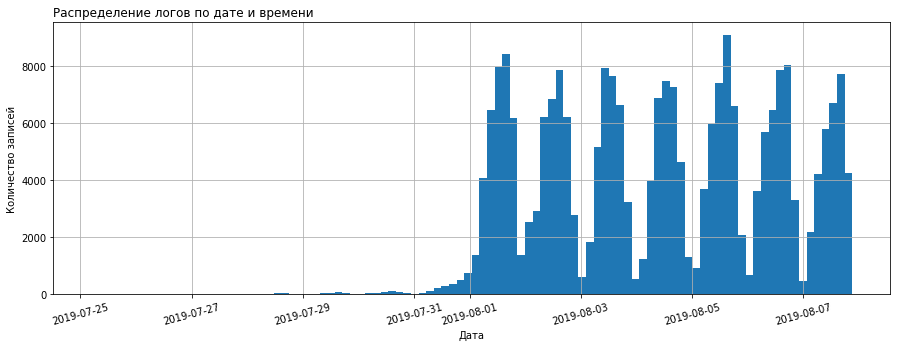

In [19]:
plt.title('Распределение логов по дате и времени', loc='left')
plt.xlabel('Дата')
plt.ylabel('Количество записей') 
df['event_time_stamp'].hist(bins=100, xrot=15,  figsize=(15, 5))
plt.show()

Здесь видно, что до конца июля у нас очень мало данных. Обозначим начало изучаемого периода как 01.08.2019

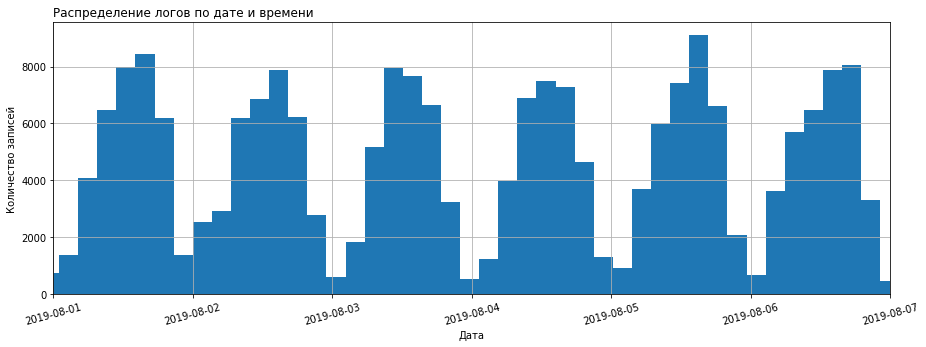

In [20]:
plt.title('Распределение логов по дате и времени', loc='left')
plt.xlabel('Дата')
plt.ylabel('Количество записей') 
df['event_time_stamp'].hist(bins=100, xrot=15,  figsize=(15, 5))
plt.xlim([datetime.date(2019, 8, 1), datetime.date(2019, 8, 7)])
plt.show()

Построим график распределения по времени дня

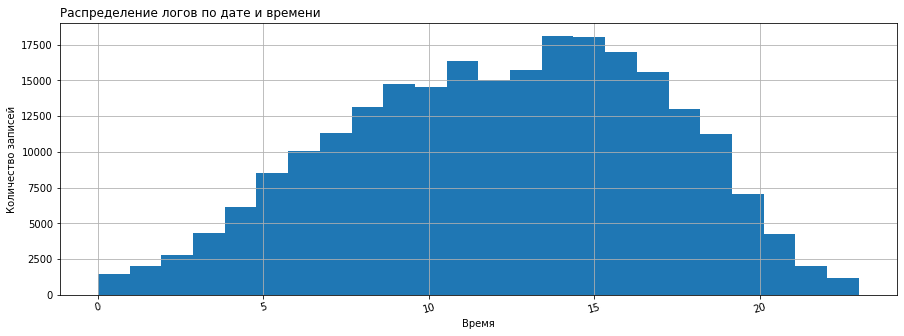

In [21]:
plt.title('Распределение логов по дате и времени', loc='left')
plt.xlabel('Время')
plt.ylabel('Количество записей') 
df['event_time_stamp'].dt.hour.hist(bins=24, xrot=15,  figsize=(15, 5))
plt.show()

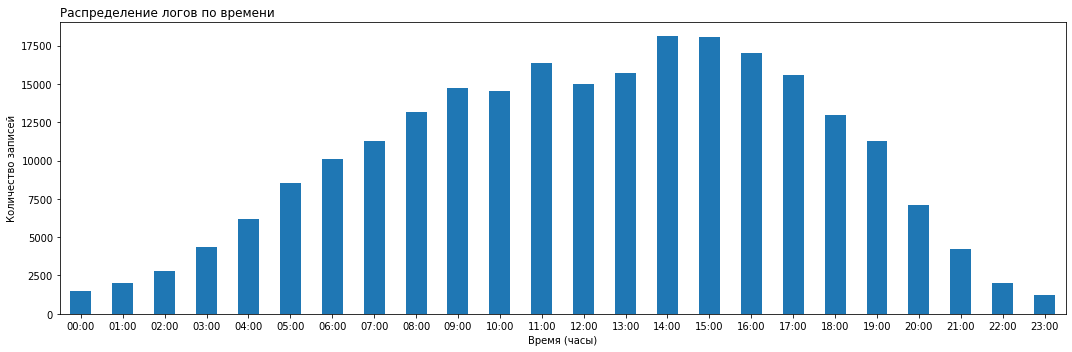

In [22]:
# Получаем количество событий для каждого часа дня
event_counts_by_hour = df['event_time_stamp'].dt.hour.value_counts().sort_index()

# Строим столбчатую диаграмму
plt.figure(figsize=(15, 5))
event_counts_by_hour.plot(kind='bar')

# Настраиваем оформление графика
plt.title('Распределение логов по времени', loc='left')
plt.xlabel('Время (часы)')
plt.ylabel('Количество записей')
plt.xticks(range(24), [f"{i:02d}:00" for i in range(24)], rotation=0)
plt.tight_layout()
plt.show()

Здесь мы видим, что наибольшая активность достигается днем - в 14 - 15 часов

**Вывод**

Проведя анализ периода, мы выяснили, что в логе отсутствует значительная часть данных за июль. Исключим эти данные из датафрейма, чтобы избежать аномалий при анализе

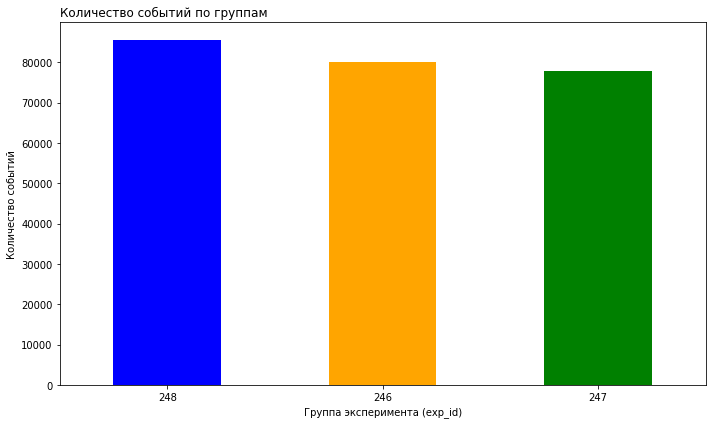

In [23]:
# Группируем данные по exp_id и считаем количество событий в каждой группе
grouped_data = df['exp_id'].value_counts()

# Строим гистограмму
plt.figure(figsize=(10, 6))
grouped_data.plot(kind='bar', color=['blue', 'orange', 'green'])

plt.title('Количество событий по группам', loc='left')
plt.xlabel('Группа эксперимента (exp_id)')
plt.ylabel('Количество событий')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [24]:
df.head(5)

,event_name,device_id_hash,event_time_stamp,exp_id,event_date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


In [25]:
df['event_date'] = pd.to_datetime(df['event_date']).dt.date

In [26]:
# Создаем сводную таблицу
pivot_table = df.pivot_table(index='event_date', columns='exp_id', aggfunc='size', fill_value=0)
print(pivot_table)

exp_id        246    247    248
event_date                     
2019-07-25      4      1      4
2019-07-26     14      8      9
2019-07-27     24     23      8
2019-07-28     33     36     36
2019-07-29     55     58     71
2019-07-30    129    138    145
2019-07-31    620    664    746
2019-08-01  11561  12306  12274
2019-08-02  10946  10990  13618
2019-08-03  10575  11024  11683
2019-08-04  11514   9942  11512
2019-08-05  12368  10949  12741
2019-08-06  11726  11720  12342
2019-08-07  10612  10091  10393


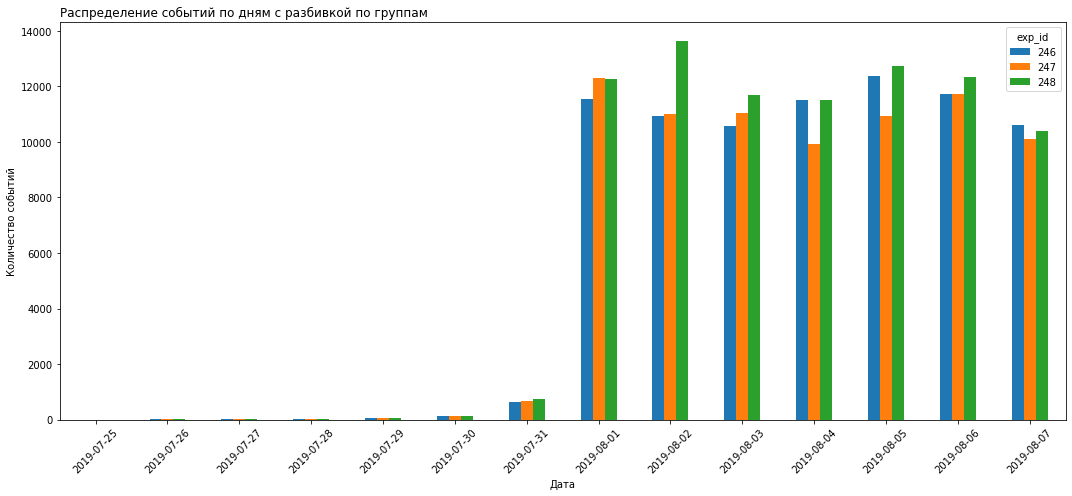

In [27]:
# Построение столбчатой диаграммы
plt.figure(figsize=(15, 7))
pivot_table.plot(kind='bar', ax=plt.gca())

plt.title('Распределение событий по дням с разбивкой по группам', loc='left')
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.xticks(rotation=45)
plt.tight_layout()

# Отображение графика
plt.show()

# Много ли событий и пользователей мы потеряли, отбросив старые данные?

Посмотрим еще раз, сколько всего у нас пользователей

In [28]:
print('Всего записей в датасете:', len(df['event_name']))
print('Всего пользователей в датасете:', df['device_id_hash'].nunique())

Всего записей в датасете: 243713
Всего пользователей в датасете: 7551


Теперь посмотрим, какую долю составляют данные за июль от общего числа

In [29]:
df_no_july = df[df['event_date'] >= '2019-08-01']

# сколько пользователей и событий потеряем при изменении периода
print(
    'Сколько пользователей потеряем при изменении периода', 
    df['device_id_hash'].nunique() - df_no_july['device_id_hash'].nunique()
)
print('Сколько событий потеряем при изменении периода', 
    len(df['event_name']) - len(df_no_july['event_name'])
)

# доля потерянных данных от общего числа
print(
    'Доля потерянных пользователей при изменении периода', 
    (df['device_id_hash'].nunique() - df_no_july['device_id_hash'].nunique()) 
    / df['device_id_hash'].nunique() * 100
)

print('Доля потерянных событий при изменении периода', 
    (len(df['event_name']) - len(df_no_july['event_name'])) 
      / len(df['event_name']) * 100
)

TypeError: '>=' not supported between instances of 'datetime.date' and 'str'

Мы видим, что потеря в пользователях и в записях незначительные

In [ ]:
df = df[df['event_date'] >= '2019-08-01']

In [ ]:
print('Записей в датасете ПОСЛЕ удаления:', len(df['event_name']))
print('Пользователей в датасете ПОСЛЕ удаления:', df['device_id_hash'].nunique())

Как мы видим, после удаления неполных данных за июль, мы потеряли только 17 пользователей. Всего мы удалили 2826 записей.

Проверьте, что у вас есть пользователи из всех трёх экспериментальных групп

Проверим, что в очищенном датасете остались пользователи из всех трех экспериментальных групп

In [ ]:
# униикальные пользователи по группам
display(df.groupby('exp_id').agg({'device_id_hash': 'nunique'}))

# общее число пользователей по группам
display(df.groupby('exp_id').agg({'device_id_hash': 'count'}))

Группы незначительно различаются по количеству уникальных пользователей и числу записей.

Группа 248 содержит наибольшее число уникальных пользователей и записей в целом.

После удаления данных за июль у нас остались данные о всех трех группах

## Анализ воронки событий

Посмотрите, какие события есть в логах, как часто они встречаются. 
Отсортируйте события по частоте
Начнем с анализа частоты событий. Посмотрим, какие события встречаются чаще всего.

In [ ]:
event_count = df['event_name'].value_counts().reset_index().sort_values(by='event_name', ascending=False)
event_count

In [ ]:
f, ax = plt.subplots(figsize = (15, 8))
ax = sns.barplot(x = 'event_name', y = event_count['index'], \
                 data = event_count, \
                 orient = 'h', palette = 'Paired')
plt.title('Частота событий')
ax.set(xlabel = 'Количество', ylabel = 'Событие')
plt.xticks(rotation=45)
plt.grid()
sns.despine()
plt.show()

При анализе суммарного количества событий мы получаем следующую последовательность:

    MainScreenAppear - 117328
    OffersScreenAppear - 46333
    CartScreenAppear - 42303
    PaymentScreenSuccessful - 33918
    Tutorial - 1005

**Посчитайте, сколько пользователей совершали каждое из этих событий. 
Отсортируйте события по числу пользователей. Посчитайте долю пользователей, которые хоть раз совершали событие.**

Посчитаем число пользователей для каждого события, а также долю пользователей


In [ ]:
event_users = (
    df.
    groupby('event_name').
    agg({'device_id_hash': 'nunique'})
    .reset_index()
    .rename(columns={'device_id_hash' : 'total_users'})
    .sort_values(by='total_users', ascending=False)
)
event_users['ratio'] = event_users['total_users'] / df['device_id_hash'].nunique() * 100
event_users

Как и на предыдущем шаге мы получили последовательность:

    MainScreenAppear - 7419 (98.474%)
    OffersScreenAppear - 4593 (60.964%)
    CartScreenAppear - 3734 (49.562%)
    PaymentScreenSuccessful - 3539 (46.974%)
    Tutorial - 840 (11.149%)

**Предположите, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку? Их не нужно учитывать при расчёте воронки.**

Сильнее всего отличаются показатели у события Tutorial, это событие прошли лишь 11% всех пользователей. Можно сделать предположение (исходя из названия события), что Tutorial - это необязательное событие, которое встречается новым пользователям и в рамках которого, пользователь учится работать с приложением. Многие пользователи пропускают его, поэтому у этого события такие низкие показатели.

Предлагаю убрать его из воронки.

In [ ]:
event_users = event_users[event_users['event_name'] != 'Tutorial']

f, ax = plt.subplots(figsize = (15, 8))

sns.barplot(x = 'total_users', y = event_users['event_name'], \
                 data = event_users, \
                 orient = 'h', palette = 'Paired')

plt.title('Частота событий')
ax.set(xlabel = 'Пользователи', ylabel = 'Событие')
plt.xticks(rotation=45)
plt.grid()
sns.despine()
plt.show()

In [ ]:
fig = go.Figure(go.Funnel(y = event_users['event_name'],
                          x = event_users['total_users'],
                          opacity = 0.6,
                          textposition = 'inside',
                          textinfo = 'value + percent previous'))
fig.update_layout(title_text='Воронка')
fig.show()

**Какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем).**

Посчитаем, какая доля пользователей проходит на следующий этап (от числа пользователей на предыдущем шаге).

In [ ]:
# процент перехода с шага 1 на 2
print(
    'Процент перехода с шага MainScreenAppear на OffersScreenAppear', 
    round(float(event_users['total_users'][event_users['event_name'] == 'OffersScreenAppear']) / 
     float(event_users['total_users'][event_users['event_name'] == 'MainScreenAppear']) * 100, 2)
)

# процент перехода с шага 2 на 3
print(
    'Процент перехода с шага OffersScreenAppear на CartScreenAppear', 
    round(float(event_users['total_users'][event_users['event_name'] == 'CartScreenAppear']) / 
     float(event_users['total_users'][event_users['event_name'] == 'OffersScreenAppear']) * 100, 2)
)

# процент перехода с шага 3 на 4
print(
    'Процент перехода с шага CartScreenAppear на PaymentScreenSuccessful', 
    round(float(event_users['total_users'][event_users['event_name'] == 'PaymentScreenSuccessful']) / 
     float(event_users['total_users'][event_users['event_name'] == 'CartScreenAppear']) * 100, 2)
)

**На каком шаге теряете больше всего пользователей?**

Больше всего пользователей отваливается при переходе с шага MainScreenAppear на OffersScreenAppear - ~ 38%

**Какая доля пользователей доходит от первого события до оплаты?**

In [ ]:
print(
    'Процент перехода с шага MainScreenAppear на PaymentScreenSuccessful', 
    round(float(event_users['total_users'][event_users['event_name'] == 'PaymentScreenSuccessful']) / 
     float(event_users['total_users'][event_users['event_name'] == 'MainScreenAppear']) * 100, 2)
)

Примерно 48% пользователей доходит от первого шага до оплаты

## Изучите результаты эксперимента

Сколько пользователей в каждой экспериментальной группе?

Посмотрим, сколько пользователей содержится в каждой из групп


In [ ]:
df.groupby('exp_id').agg(count=('device_id_hash', 'nunique'))

**Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверьте, находят ли статистические критерии разницу между выборками 246 и 247.
Проверим, находят ли статистические критерии разницу между группой 246 и 247**

Критерии успешного A/A-теста:

    Количество пользователей в различных группах различается не более, чем на 1%;
    Для всех групп фиксируют и отправляют в системы аналитики данные об одном и том же;
    Различие ключевых метрик по группам не превышает 1% и не имеет статистической значимости;
    Попавший в одну из групп посетитель остаётся в этой группе до конца теста. Если пользователь видит разные версии исследуемой страницы в ходе одного исследования, неизвестно, какая именно повлияла на его решения. Значит, и результаты такого теста нельзя интерпретировать однозначно.

Проверим, есть ли пользователи, которые состоят сразу в нескольких группах

In [ ]:
# посмострим, есть ли значения, которые встречаются в обеих контрольных группах
print('Пересечение между группой 246 и 247:', len(
    np.intersect1d(df
                   .query('exp_id == 246')['device_id_hash']
                   .unique(), df.query('exp_id == "247"')['device_id_hash'].unique())))

# посмострим, есть ли значения, которые встречаются в первой контрольной группе и в эксперементальной
print('Пересечение между группой 246 и 248:', len(
    np.intersect1d(df
                   .query('exp_id == 246')['device_id_hash']
                   .unique(), df.query('exp_id == "248"')['device_id_hash'].unique())))

# посмострим, есть ли значения, которые встречаются во второй контрольной группе и в эксперементальной
print('Пересечение между группой 247 и 248:', len(
    np.intersect1d(df
                   .query('exp_id == 247')['device_id_hash']
                   .unique(), df.query('exp_id == "248"')['device_id_hash'].unique())))

Мы видим, что наши группы содержат уникальных пользователей и не пересекаются между собой

Сгруппируем данные по экспериментальным группам и событиям, а затем визуализируем их

In [ ]:
exp_group = (
    df.groupby(['event_name', 'exp_id'])
    .agg({'device_id_hash': 'nunique'})
    .reset_index()
    .rename(columns={'device_id_hash' : 'total_users'})
    .sort_values(by=['exp_id','total_users'], ascending=False)
)


# исключим событие 'Tutorial'
exp_group = exp_group[exp_group['event_name'] != 'Tutorial']

In [ ]:
fig = go.Figure()

fig.add_trace(go.Funnel(name = '246',
                        y = exp_group.query('exp_id == 246')['event_name'],
                        x = exp_group.query('exp_id == 246')['total_users'],
                        opacity = 0.8,
                        textposition = 'inside',
                        textinfo = 'value + percent previous'))

fig.add_trace(go.Funnel(name = '247',
                        y = exp_group.query('exp_id == 247')['event_name'],
                        x = exp_group.query('exp_id == 247')['total_users'],
                        opacity = 0.8,
                        textposition = 'inside',
                        textinfo = 'value + percent previous'))


fig.add_trace(go.Funnel(name = '248',
                        y = exp_group.query('exp_id == 248')['event_name'],
                        x = exp_group.query('exp_id == 248')['total_users'],
                        opacity = 0.8,
                        textposition = 'inside',
                        textinfo = 'value + percent previous'))
                        
fig.update_layout(title_text='Воронка событий по группам')
fig.show()

Мы видим, что пользователи равномерно распределены между группами. Однако, прежде чем приступить к проведению A/B теста, проверим, есть ли разница между выборками и контрольными группами (246, 247).

Воспользуемся Z-критерием. Сейчас в воронке у нас 4 события, а пользователи разделены на 3 группы. Таким образом, мы проведем сравнение каждой из групп с другой, также проведем сравнение объединенной группы (246 и 247) с группой 248. Таким образом мы получим 16 итераций сравнений.

In [ ]:
# функция принимает датафреймы с группами, событие, статистическую значимость и значение для поправки Бонферрони

def z_test_func(df1, df2, event, alpha, n):
    
    # произведем поправку Бонферрони
    bonferroni_alpha = alpha / n
    
    #число пользователей в 1 и 2 группе
    n_users = np.array([df1['device_id_hash'].nunique(), 
                        df2['device_id_hash'].nunique()])
    
    # число пользователей, которые совершили событие в 1 и 2 группе
    success = np.array([df1[df1['event_name'] == event]['device_id_hash'].nunique(), 
                        df2[df2['event_name'] == event]['device_id_hash'].nunique()])
    
    # пропорции успехов в группах:
    p1 = success[0]/n_users[0]
    p2 = success[1]/n_users[1]
    
    # пропорции успехов в объединенном датасете
    p_combined = (success[0] + success[1]) / (n_users[0] + n_users[1])

    # разница пропорций
    difference = p1 - p2 

    #считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/n_users[0] + 1/n_users[1]))
    
    #задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2
        
    print('Событие:', event)
    print('p-значение: ', p_value)

    if p_value < bonferroni_alpha:
        print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
    else:
        print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")

Применим написанную выше функцию. Перед началом теста, сформулируем наши гипотезы:

**H0 - между группами нет статистически значимых различий**

**H1 - между группами есть статистически значимых различий**

Проведем сравнение по следующему плану:

    Сравнение группы 246 и группы 247
    Сравнение группы 246 и группы 248
    Сравнение группы 247 и группы 248
    Сравнение объединенной группы (246 и 247) и экспериментальной 248
Cравнение группы 246 и группы 247

In [ ]:
for event in exp_group['event_name'].unique():
    z_test_func(df[df['exp_id'] == 246], df[df['exp_id'] == 247], event, .05, 16)
    print()

Здесь мы сравнили две контрольные группы - т.е. провели A/A тест. мы видим, что между выборками нет статистически значимых отличий, следовательно, разделение по группам работало корректно

Теперь сравним каждую из контрольных групп с экспериментальной, по отдельности

Сравнение группы 246 и группы 248

In [ ]:
for event in exp_group['event_name'].unique():
    z_test_func(df[df['exp_id'] == 246], df[df['exp_id'] == 248], event, .05, 16)
    print()

Между первой контрольной группой (246) и экспериментальной группой (248) нет различий

Сравнение группы 247 и группы 248

In [ ]:
for event in exp_group['event_name'].unique():
    z_test_func(df[df['exp_id'] == 247], df[df['exp_id'] == 248], event, .05, 16)
    print()

Как и в предыдущем тесте, нет различий между контрольной (247) и экспериментальной (248) группами

Теперь объединим контрольные группы (246 и 247) и сравним их с экспериментальной (248)

In [ ]:
for event in exp_group['event_name'].unique():
    z_test_func(df[df['exp_id'] != 248], df[df['exp_id'] == 248], event, .05, 16)
    print()

Здесь, как и во всех тестах ранее, не получилось опровергнуть нулевую гипотезу

**Вывод**

Изучив все комбинации групп, можно сделать вывод, что ни в одном из случаем, значимых различий между группами не наблюдается. Получается, что изменение шрифта не повлияло на пользователей.

# Общий вывод

В ходе исследования мы проанализировали поведение пользователей мобильного приложения и результаты A/A/B-эксперимента. Задача теста - определить, понравится ли пользователям новый шрифт.

**Структура теста**

Пользователей разбили на 3 группы:

2 контрольные (246, 247) со старыми шрифтами и одну экспериментальную (248) — с новыми.

Задача - выяснить, какой шрифт лучше.

**Анализ поведения пользователей**

Данные о пользователях отслеживались в период с 25.07.2019 по 07.08.2019 Важно отметить, что данные за июль были неполными и мы решили изучать поведение в период с 01.08.2019 по 07.08.2019 Здесь мы также изучили процент потерянных данных, всего было утрачено около 1% записей, поэтому подобные изменения не должны были повлиять на результаты исследования.

    MainScreenAppear - 7419 - (98.47%)
    OffersScreenAppear - 4593 - (60.96%)
    CartScreenAppear 3734 - (49.56%)
    PaymentScreenSuccessful - 3539 (46.97%)
    Tutorial - 840 (11.15%)
    
Последнее событие, 'Tutorial', мы исключили из анализа. Дело в том, что это необязательное событие, которое многие пользователи пропускают.

Анализируя воронку мы увидели, что больше всего пользователей отваливаются после первого этапа MainScreenAppear, т.е. 38: пользователей. Дальше по воронке показатели стабильнее. 81.3% переходят с OffersScreenAppear на CartScreenAppear. А переход к оплате (шаг PaymentScreenSuccessful) с предыдущего шага составляет 94.8%

Если же смотреть, какая часть пользователей доходит от начала взаимодействия до оплаты, то получится 48%

Результаты A/B теста показали, что изменение шрифта не повлияло на пользователей, выборки, как контрольные так и экспериментальная показали результаты, между которыми нет значительной статистической разницы.

**Рекомендации**

Нужно изучить причину, по которой данные за июль оказались неполными. В дальнейшем подобные проблемы могут привести к сложностям в исследованиях и расчетах метрик приложения.

Также важно изучить высокий показатель отказов при переходе с шага MainScreenAppear на OffersScreenAppear. Это может быть связано как с тем, что пользователю не интересно смотреть на офферы, так и с техническими проблемами.

<div style="border:solid Purple 2px; padding: 40px">

<h2> Общий комментарий ревьюера 😊<a class="tocSkip"> </h2>
    <br/>
Замечательная работа по проекту, отлично справился с расчетами и графиками)
    
<br>   
             
**Дополнительные материалы:**
 
[Вебинары под эгидой Практикума](https://vk.com/yandex.praktikum?w=wall-176471180_2144), 
    
[Лекции Анатолия Карпова 1](https://www.youtube.com/watch?v=jnFVmtaeSA0&list=WL&index=19&t=2s) [2](https://www.youtube.com/watch?v=gljfGAkgX_o&list=WL&index=4)
    
Материалы [gopractice](https://gopractice.ru/summary/)

Лекцию Карта статистических методов [Смотреть видео](https://www.youtube.com/watch?v=-zps6hm0nX8&t=1269s)
        
Статья «Множественные эксперименты: теория и практика» [Читать статью](https://habr.com/ru/company/yandex/blog/476826/)
    
Статья «Как не надо анализировать A/B тесты. Проблема подглядывания» [Читать статью](https://gopractice.ru/how-not-to-analyze-abtests/)
    
Видеодоклад «Дешёвые и дорогие тесты гипотез», Светлана Аюпова из Skyeng [Смотреть видео](https://youtu.be/MD6ysrdI4Ro)